In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import re

from tqdm import tqdm

random_state = 12345
NUM_ITERATIONS = 5000

import json
import os

In [277]:
# Расшифровка прогноза в колонке 'weather_pred'

# функция формирует колонки 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability', 'has_rain_probability'
# в колонках число, которое 0 при отсутсвии упоминания явления в weather_pred или степень упоминания
# функция дает в колонках номер первого списка, элемент которого есть в строке плюс 1
# списки cloudy_list, rainy_list, windy_list, clear_list можно модифицировать
# соответственно, можно экспериментировать с расположением значений в списках
# например, сейчас 'дождь', 'снег', 'д+сн' - первая степень  дождя, а 'гроз', 'ливень' - вторая
# а можно сделать снег второй, а грозу с ливнем убрать в третью
# также сделал отдельный список для "ясности", чтобы выделить 'ясно' и 'солнечно'

def in_what_list(weather, big_list):
    for list_number, small_list in enumerate(big_list):
        if any(word in weather for word in small_list):
            return list_number+1
    return 0

def weather_split2(row):
    weather = row['weather_pred']
    cloudy_list = [['проясн', 'пер.об.', 'п/об'], ['пасм', 'обл']]
    rainy_list = [['дождь', 'снег', 'д+сн'], ['гроз', 'ливень']]
    windy_list = [['вет'],['штор']]
    clear_list = [['проясн'], ['ясно'], ['солнеч']]
    numbers = re.findall(r'\d+', weather)
    cloudy = in_what_list(weather, cloudy_list)
    rainy = in_what_list(weather, rainy_list)
    windy = in_what_list(weather, windy_list)
    clear = in_what_list(weather, clear_list)
    rain_probability = 0 if len(numbers)==0 else int(numbers[0])
    has_rain_probability = int(len(numbers)==0)
    return cloudy, rainy, windy, clear, rain_probability, has_rain_probability

def fill_weather_columns(df):
    df['weather_pred'] = df['weather_pred'].fillna('')
    df['cloudy'], df['rainy'], df['windy'], df['clear'], df['rain_probability'], df['has_rain_probability'] = \
                zip(*df.apply(weather_split2, axis=1))
    return df

Некоторые научные работы указывают на прямую связь величины потребления электричества и показателя ВВП, который отражает ситуацию в экономике. Данные по экономике публикуются различными министерствами с разной периодичностью. Для использования в работе были взяты фактические данные по ВВП с сайта investing, который агрегирует публикации Минэкономразвития. Данные за месяц побликуются с месячной задержкой, поэтому модель использует для прогнозирования данные за прошлые месяцы, которые известны. Ссылка на данные: https://ru.investing.com/economic-calendar/russian-monthly-gdp-407


In [278]:
# Функция добавляет данные о ВВП из файла 'data/VVP.csv' в датасет

def add_vvp2(data, file_source = 'data/VVP.csv'):
    """
    сырой датафрем подаем на вход
    """
    # обработаем файл с динамикой ВВП
    vvp = pd.read_csv(file_source)
    # преобразуем дату файла-источника в формат datetime64 и дропнем один столбик
    vvp['date'] = pd.to_datetime(vvp['date'], format ='%Y-%m-%d %H:%M:%S')
    vvp.drop('for_month',axis=1,inplace=True) 
    
    # обработаем основной фрейм - создадим столбец для соединения, который потом удалим
    data['date_temp'] = pd.to_datetime(data['date'], format = '%Y-%m-%d' )
    data['date_temp'] = data['date_temp'] + pd.to_timedelta(data['time'] , 'H')
    
    # соединяем основной фрейм и ВВП по дате объявления показтеля ВВП
    for idx in reversed(vvp.index):
        data.loc[data['date_temp']>=vvp.date[idx],'VVP'] = vvp.VVP_perc[idx]
        
    data.drop('date_temp',axis=1,inplace=True)   

    return data

In [279]:
# Функции для работы с данными о фактической погоде из 'data/preprocessing_loaded_table.csv'

# Кодировка информации об осадках из колонки WW
def true_weather_WW_replace(ww):
    if ww=='нет осадков':
        return 0
    elif ww=='слабый дождь':
        return 1
    elif (ww=='сильный дождь') or (ww=='снег'):
        return 2
    else:
        return 3

# Вычисление Timestamp из даты и времени
def row_plus_hours_to_index(row):
    return row['date'] + pd.to_timedelta(row['time'] , 'H')

# Функция для сдвига на сутки (в скачанном датасете разбивка по 30 мин, поэтому timeshift=48)
def shift_features_fact(df, timeshift=48):
    list_fact_columns=list([df.columns])
    new_df = df.copy()
    for column in list_fact_columns:
        new_df[column] = new_df[column].shift(timeshift)

    return new_df

In [280]:
# Функция для выделения временных интервалов из таблиц признаков и целей
# на этом этапе отбрасываем колонку 'date'

def features_interval(features, target, date1, date2):
    features_interval = features[ (features['date']>=date1) & (features['date']<date2) ]
    target_interval = target[features_interval.index]
    features_interval = features_interval.drop('date', axis=1)
    return features_interval, target_interval

In [281]:
# Функция для вычисления метрики mae по дням из почасовых массивов данных

def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)

In [282]:
# Функция для вычисления метрик по дням из почасовых массивов данных

def metrics_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    mae = mean_absolute_error(y_true_grouped, y_pred_grouped)
    mape = mean_absolute_percentage_error(y_true_grouped, y_pred_grouped)
    r2 = r2_score(y_true_grouped, y_pred_grouped)
    return mae, mape, r2

In [283]:
# Класс для подбора гиперпараметров методом аппроксимации параболой по трем точкам

# класс предлагается инициализировать, затем брать значения параметра из current_value 
# и регистрировать значения метрики методом add_metric_value, пока add_metric_value не вернет True

# параметры инициализации: 
# initial_values - начальный вектор значений параметра, может быть любой длины
# stop_relation - целевое отношение соседних значений параметра для остановки поиска
# step_method - способ формирования трех точек для первой параболы дугой вниз
# step_method = 'geometric' - делим или умножаем значение с минимальной метрикой на geometric_step
# step_method = 'dichotomy' - делим интервал с минимальной метрикой на границах пополам
# step_method = 'geometric_dichotomy' - делим интервал с минимальной метрикой на границах средним геометрическим

class one_parameter_parabolic_optimizer:
    def __init__(self, initial_values, stop_relation=1.1, step_method='nothing', geometric_step=2):      
        self.data = pd.DataFrame(columns=('parameter','metric','x2','x','1'), dtype='float')
        self.parabolic_mode = False
        self.parabolic_error = False
        self.stop_relation_log = np.log(stop_relation)
        self.initial_values = initial_values            
        self.step_method = step_method                              
        self.geometric_step = geometric_step
        self.initial_counter = 0
        self.current_value = self.initial_values[0]
        
    def best_value(self):
        return self.data.loc[self.data['metric'].idxmin(), 'parameter']
    
# строим параболу через точку с минимальной метрикой и две соседние и ищем ее минимум
    def next_parabolic(self):                      
        self.data['x2'] = self.data['parameter']**2
        self.data['x'] = self.data['parameter']
        self.data['1'] = 1
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()
        matrix = self.data[['x2','x','1']][index_min-1:index_min+2]
        y = self.data['metric'][index_min-1:index_min+2]
        vector_abc = np.linalg.inv(matrix) @ y
        return -vector_abc[1]/vector_abc[0]/2

    def next_geometric(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return self.data.loc[index_min, 'parameter']/self.geometric_step
        else:
            return self.data.loc[index_min, 'parameter']*self.geometric_step
        
    def next_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min+1, 'parameter'])/2
        else:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min-1, 'parameter'])/2
        
    def next_geometric_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min+1, 'parameter'])**0.5
        else:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min-1, 'parameter'])**0.5
    
    def add_metric_value(self, metric_value):
        if self.parabolic_error:           # записана ошибка, выход
                return True
        self.data.loc[self.data.shape[0]] = [self.current_value, metric_value, 0, 0, 0]   # новое значение в таблицу
        if self.initial_counter+1 < len(self.initial_values) :              # если начальные значения не закончились,
            self.initial_counter+=1                                         # то считаем метрику в них
            self.current_value = self.initial_values[self.initial_counter]
            return False
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()         # ищем минимальную метрику
        parabolic_ready = (index_min!=0) and (index_min!=self.data.shape[0]-1)      # и выясняем, на краю ли она таблицы
        if parabolic_ready:
            self.parabolic_mode = True                               # если не на краю, дальше считаем параболой                  
            self.current_value = self.next_parabolic()
            loglog = abs(np.array([np.log(self.data.loc[index_min-1,'parameter'])-np.log(self.data.loc[index_min,'parameter']),
                              np.log(self.data.loc[index_min+1,'parameter']) -np.log(self.data.loc[index_min,'parameter'])]))            
            return loglog.min() < self.stop_relation_log   # пока не выполним критерий
        elif self.parabolic_mode:    # если уже была парабола, а теперь не получается, то пишем ошибку: метод расходится
            return True
        elif self.step_method == 'geometric': # если еще нет точек для параболы и задана геометрическая прогрессия
            self.current_value = self.next_geometric()
            return False
        elif self.step_method == 'dichotomy': # если еще нет точек для параболы и задана дихотомия 
            self.current_value = self.next_dichotomy()
            return False
        elif self.step_method == 'geometric_dichotomy': # если еще нет точек для параболы и задана geometric_dichotomy 
            self.current_value = self.next_geometric_dichotomy()
            return False
        else: # если еще нет точек для параболы и метод поиска не задан, завершаем
            return True

In [284]:
# читаем исходные датасеты и складываем в один
train_ds = pd.read_csv('data/train_dataset.csv')
test_ds = pd.read_csv('data/test_dataset.csv')
train_ds = pd.concat([train_ds, test_ds])

# запоминаем дату начала тестовых данных, потом также поступим и с закрытым датасетом
open_test_begin = pd.to_datetime(test_ds['date']).min()
open_test_end = pd.to_datetime(test_ds['date']).max() + pd.to_timedelta(1,'d')
print('начало открытого теста:', open_test_begin, '    конец открытого теста:', open_test_end)

начало открытого теста: 2023-04-01 00:00:00     конец открытого теста: 2023-08-01 00:00:00


In [285]:
# преобразуем дату и делаем из нее колонки
train_ds['date'] = pd.to_datetime(train_ds['date'])
train_ds['year'] = train_ds['date'].dt.year
train_ds['month'] = train_ds['date'].dt.month
train_ds['day_of_week'] = train_ds['date'].dt.dayofweek
train_ds['day'] = train_ds['date'].dt.day
train_ds['day_of_year'] = train_ds['date'].dt.dayofyear

In [286]:
# Расшифровка прогноза в колонке 'weather_pred'
train_ds = fill_weather_columns(train_ds)

In [287]:
# Добавление данных о праздниках из файла 'data/holidays.csv'

df_holidays = pd.read_csv('data/holidays.csv')
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# Assuming df_holidays and train_ds are your dataframes
train_ds = pd.merge(train_ds, df_holidays, on='date', how='left')

# Fill NaN values with 0
train_ds['holidays'].fillna(0, inplace=True)
train_ds['preholidays'].fillna(0, inplace=True)

# Convert to int
train_ds['holidays'] = train_ds['holidays'].astype(int)
train_ds['preholidays'] = train_ds['preholidays'].astype(int)

In [288]:
# Добавление колонок с временными лагами

# создаем столбец 'temp_last_day'
train_ds['temp_last_day'] = train_ds['temp'].shift(24)

# заполняем пропущенные значения в 'temp_last_day'
train_ds['temp_last_day'].fillna(method='bfill', inplace=True)

# создаем столбцы с временными лагами для 'target'
lags = [24, 48, 72, 7*24, 14*24]
for lag in lags:
    train_ds[f'target_lag_{lag}'] = train_ds['target'].shift(lag)

# заполняем пропущенные значения в столбцах с лагами
for lag in lags:
    train_ds[f'target_lag_{lag}'].fillna(0, inplace=True)

In [289]:
# применяем функцию добавления ВВП
train_ds = add_vvp2(train_ds)

In [290]:
# Читаем файл с архивом фактической погоды
df_true_weather = pd.read_csv('data/preprocessing_loaded_table.csv')
display(df_true_weather)

# Форматируем колонки
df_true_weather['WW'] = df_true_weather['WW'].apply(true_weather_WW_replace)
df_true_weather['date'] = pd.to_datetime(df_true_weather['date'])
df_true_weather = df_true_weather.rename(columns={'date':'date_tw'})
# Применяем сдвиг на сутки, чтобы не заглядывать в будущее
df_true_weather = shift_features_fact(df_true_weather)
# Добавляем в датасет
train_ds['date_hours'] = train_ds.apply(row_plus_hours_to_index, axis=1)
train_ds = train_ds.merge(df_true_weather, left_on='date_hours', right_on='date_tw')
train_ds = train_ds.drop(['date_hours', 'date_tw'], axis=1)

,date,P,U,WW,Td,N,S,W,E
0,2018-12-31 00:00:00,763.5,100.0,слабый дождь,2.0,1.0,0.0,0.0,0.0
1,2018-12-31 00:30:00,764.3,93.0,слабый дождь,1.0,1.0,0.0,0.0,0.5
2,2018-12-31 01:00:00,764.3,93.0,слабый дождь,1.0,1.0,0.0,0.0,0.0
3,2018-12-31 01:30:00,765.0,93.0,слабый дождь,2.0,1.0,0.0,0.0,0.0
4,2018-12-31 02:00:00,765.0,93.0,нет осадков,2.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
82146,2023-09-30 21:30:00,763.5,82.0,нет осадков,12.0,0.0,0.0,1.0,0.0
82147,2023-09-30 22:00:00,763.5,82.0,нет осадков,12.0,0.5,0.0,1.0,0.0
82148,2023-09-30 22:30:00,763.5,77.0,сильный дождь,11.0,0.0,0.0,1.0,0.0
82149,2023-09-30 23:00:00,763.5,94.0,сильный дождь,13.0,0.5,0.0,1.0,0.0


In [291]:
# Итоговый набор колонок
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'holidays', 'preholidays', 'temp_last_day',
       'target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_168',
       'target_lag_336', 'VVP', 'P', 'U', 'WW', 'Td', 'N', 'S', 'W', 'E'],
      dtype='object')

In [292]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,...,target_lag_336,VVP,P,U,WW,Td,N,S,W,E
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0.0,1.8,765.0,87.0,0.0,0.0,0.0,1.0,0.5,0.0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0.0,1.8,763.5,81.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0.0,1.8,762.8,87.0,1.0,1.0,0.0,1.0,1.0,0.0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0.0,1.8,761.2,93.0,1.0,2.0,0.0,1.0,1.0,0.0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0.0,1.8,759.7,93.0,1.0,3.0,0.0,1.0,1.0,0.0


In [293]:
# Отбираем признаки. Все лишние колонки здесь отбрасываем, кроме 'date', которую уберем позже 

feature_cols = list(train_ds.columns)

# выбрасываем взгляд в прошлое и расшифрованную погоду
drop_list = ['target', 'day_of_year', 'weather_pred', 'weather_fact', 'temp']

# выбрасываем признаки, найденные процедурно в процессе оптимизации
# КОМАНДЕ: здесь можно добавлять признаки на выброс с целью оптимизации
drop_list = drop_list + ['target_lag_48', 'target_lag_168'] #, 'temp_pred'] #, 'target_lag_336'] 

for name in drop_list:
    feature_cols.remove(name)

# Итоговый список признаков
feature_cols

['date',
 'time',
 'temp_pred',
 'year',
 'month',
 'day_of_week',
 'day',
 'cloudy',
 'rainy',
 'windy',
 'clear',
 'rain_probability',
 'has_rain_probability',
 'holidays',
 'preholidays',
 'temp_last_day',
 'target_lag_24',
 'target_lag_72',
 'target_lag_336',
 'VVP',
 'P',
 'U',
 'WW',
 'Td',
 'N',
 'S',
 'W',
 'E']

In [294]:
# Формируем набор датасетов для обучения и проверки

features = train_ds[feature_cols]
target = train_ds['target']

# для первичного подбора гиперпараметров будем обучать на 19-21 годах, валидировать по 2022
features_train, target_train = features_interval(features, target, '2019-01-01', '2022-01-01')
features_valid, target_valid = features_interval(features, target, '2022-01-01', '2023-01-01')

# отбор признаков будем производить, обучая на 19-22 и проверяя по первому кварталу 2023
# с дополнительным контролем на вариантах из первичного обучения
features_2022, target_2022 = features_interval(features, target, '2019-01-01', '2023-01-01')
features_2023, target_2023 = features_interval(features, target, '2023-01-01', open_test_begin)

# для проверки на тестовой выборке будем учиться на всем тренировочном датасете
features_all_train, target_all_train = features_interval(features, target, '2019-01-01', open_test_begin)
features_open_test, target_open_test = features_interval(features, target, open_test_begin, open_test_end)

In [295]:
# формируем наборы данных по кварталам 2022 года, чтобы посмотреть по ним метрику отдельно
dates = ['2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01', '2023-01-01']
quarters = []
for i in range(4):
    f, t = features_interval(features, target, dates[i], dates[i+1])
    quarters.append({'features':f, 'target':t})

# Здесь заканчивается формирование датасетов и начинается обучение

In [296]:
%%time

# Подбор параметра learning_rate для модели LightGBM
optimizer = one_parameter_parabolic_optimizer([0.1], 1.03, step_method='geometric')
for i in range(10):
    learning_rate = optimizer.current_value
    lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=learning_rate, num_iterations=NUM_ITERATIONS, random_state=random_state, objective='regression_l1', n_jobs=-1)
    lgbm_model.fit(features_train, target_train)
    mae = mae_day(target_valid, lgbm_model.predict(features_valid))
    print(f'learning rate = {learning_rate:.5f} mae = {mae:.1f}')
    if optimizer.add_metric_value(mae):
        break
best_learning_rate_1000 = optimizer.best_value()

c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.10000 mae = 150.4


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.05000 mae = 153.5


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.20000 mae = 159.6


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.10509 mae = 148.0


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.14197 mae = 162.3


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.11389 mae = 143.1


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.11782 mae = 150.7


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.11092 mae = 153.7
CPU times: total: 2min 53s
Wall time: 1min 12s


In [297]:
%%time

# Подбор параметра feature_fraction для модели LightGBM
optimizer = one_parameter_parabolic_optimizer([0.2, 1], 1.03, step_method='dichotomy')
for i in range(10):
    feature_fraction = optimizer.current_value
    lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000,  
                               num_iterations=NUM_ITERATIONS, 
                               feature_fraction=feature_fraction, random_state=random_state, 
                               objective='regression_l1', n_jobs=-1)
    lgbm_model.fit(features_train, target_train)
    mae = mae_day(target_valid, lgbm_model.predict(features_valid))
    print(f'feature_fraction = {feature_fraction:.5f} mae = {mae:.1f}')
    if optimizer.add_metric_value(mae):
        break
best_feature_fraction = optimizer.best_value()

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.20000 mae = 232.4
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 1.00000 mae = 143.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.60000 mae = 154.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.80000 mae = 152.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.90000 mae = 154.7
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.95000 mae = 159.0
[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.97500 mae = 159.0
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.98750 mae = 143.1
CPU times: total: 3min 1s
Wall time: 1min 16s


In [298]:
# Демонстрация предсказания с подобранными гиперпараметрами
# Тренируем на 19-21 годах, предсказываем за 2022

lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=NUM_ITERATIONS, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model.fit(features_train, target_train)

y_pred = lgbm_model.predict(features_valid)
mae = mae_day(target_valid, y_pred)
print(f'mae_of_the_day - {mae}')
print(f'mae of the hour - {mean_absolute_error(target_valid, y_pred)}')

[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


mae_of_the_day - 143.08959293762672
mae of the hour - 8.778930599660146


<AxesSubplot:xlabel='date'>

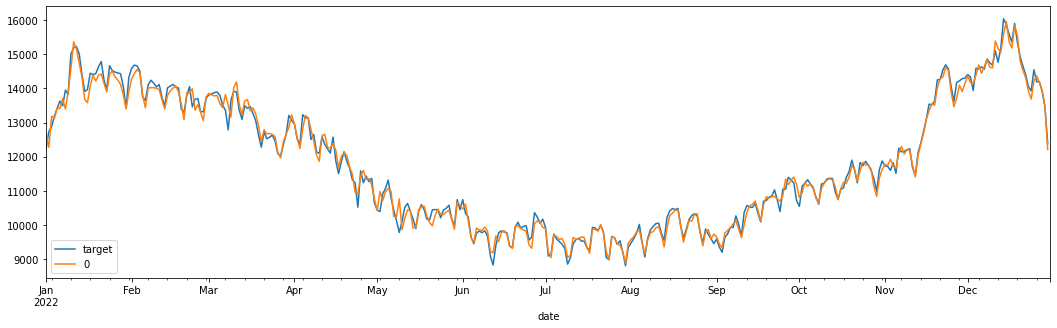

In [299]:
# Рисуем графическое представление предсказания на 2022 год

y_true_copy = pd.DataFrame(target_valid).reset_index(drop=True)
y_true_copy['day'] = y_true_copy.index // 24
y_true_grouped = y_true_copy.groupby(by='day').sum()   
y_true_grouped
y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
y_pred_copy['day'] = y_pred_copy.index // 24
y_pred_grouped = y_pred_copy.groupby(by='day').sum()

#pd.DataFrame(date_valid)
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_true_grouped)
tmpdf.plot(x='date', y='target', figsize=(18,5))
ax=plt.gca()
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_pred_grouped)
tmpdf.plot(ax=ax, x='date', y=0)

In [300]:
# Предсказываем отдельно по четырем кварталам 2022 года

for i, quarter in enumerate(quarters):
    mae = mae_day(quarter['target'], lgbm_model.predict(quarter['features']))
    print(f'{i} квартал mae = {mae}')

0 квартал mae = 186.7734576711938
1 квартал mae = 139.8451366788462
2 квартал mae = 111.72196369485604
3 квартал mae = 131.02403221789913


In [301]:
# Предсказываем той же моделью (19-21) тренировочный кусок 2023 (первый квартал)
mae = mae_day(target_2023, lgbm_model.predict(features_2023))
print(f'mae = {mae}')

mae = 154.79278450680846


In [302]:
# Учим модель на 19-22 годах и предсказываем на тренировочный кусок 2023 (первый квартал)
# Это предсказание считаем основной валидационной базой для подбора признаков

lgbm_model_2022 = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=NUM_ITERATIONS, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model_2022.fit(features_2022, target_2022)
mae = mae_day(target_2023, lgbm_model_2022.predict(features_2023))
print(f'mae = {mae}')
mae_base = mae

[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


mae = 139.54882008625773


In [303]:
# Процедурный отбор признаков
# перебираем признаки, пробуем отбросить каждый и предсказать без него

feature_cols_no_date = feature_cols.copy()
feature_cols_no_date.remove('date')
feature_drop_list = []
for feature_name in feature_cols_no_date:
    tmp_train, tmp_valid = features_2022.copy(), features_2023.copy()
    tmp_train = tmp_train.drop(feature_name, axis=1)
    tmp_valid = tmp_valid.drop(feature_name, axis=1)
    lgbm_model_feature_drop = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=NUM_ITERATIONS, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
    lgbm_model_feature_drop.fit(tmp_train, target_2022)
    mae = mae_day(target_2023, lgbm_model_feature_drop.predict(tmp_valid))
    feature_drop_list.append([feature_name, mae])
    print(f'dropped {feature_name} ----------> mae = {mae}')

[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped time ----------> mae = 221.56079861214337
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped temp_pred ----------> mae = 137.44283666723493
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped year ----------> mae = 141.7090165591792
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped month ----------> mae = 160.80683252874044
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped day_of_week ----------> mae = 265.15972197175904
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped day ----------> mae = 160.92682364054846
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped cloudy ----------> mae = 144.26907836867335
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped rainy ----------> mae = 146.9358908736424
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped windy ----------> mae = 138.30113155971162
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped clear ----------> mae = 135.81222232889368
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped rain_probability ----------> mae = 141.86547821337444
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped has_rain_probability ----------> mae = 140.48186889767334
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped holidays ----------> mae = 135.88314183283043
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped preholidays ----------> mae = 135.3949172508441
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped temp_last_day ----------> mae = 151.15727132698316
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped target_lag_24 ----------> mae = 183.45058780641548
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped target_lag_72 ----------> mae = 152.44544659286046
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped target_lag_336 ----------> mae = 135.96782392761742
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped VVP ----------> mae = 153.972142289071
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped P ----------> mae = 144.95678617319777
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped U ----------> mae = 147.28006199980067
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped WW ----------> mae = 139.4954084718961
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped Td ----------> mae = 156.82973459297858
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped N ----------> mae = 137.18302973402564
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped S ----------> mae = 141.49087316042056
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped W ----------> mae = 140.96369917299606
[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


dropped E ----------> mae = 136.1815350906882


In [304]:
# Процедурный отбор признаков
# Таблица названий признаков с изменениями метрики на валидации (первый квартал 2023) при отключении каждого
# В качестве дополнительного контроля при отключении признаков будем смотреть на изменении метрики за весь 2022 при обучении на 19-21
# С учетом дополнительного контроля по 2022 данный набор признаков считам финальным

feature_drop_list_df = pd.DataFrame( feature_drop_list, columns=['feature_name','mae_improvement']).sort_values(by='mae_improvement')
feature_drop_list_df['mae_improvement'] = mae_base - feature_drop_list_df['mae_improvement']
feature_drop_list_df.head()

,feature_name,mae_improvement
13,preholidays,4.153903
9,clear,3.736598
12,holidays,3.665678
17,target_lag_336,3.580996
26,E,3.367285


In [305]:
print('learning_rate = ', best_learning_rate_1000)
print('feature_fraction = ', best_feature_fraction)

learning_rate =  0.11388721696140795
feature_fraction =  0.9875


In [306]:
# this was at 2 drops too, hmm
#learning_rate =  0.02
#feature_fraction =  0.9875
# base mae = 136
# test mae = 108

In [307]:
# this was at 2 drops
# learning_rate =  0.00387870312757062
# feature_fraction =  0.9875
# base mae = 148.72177561808167
# test mae = 121.41877699631416

<AxesSubplot:ylabel='0'>

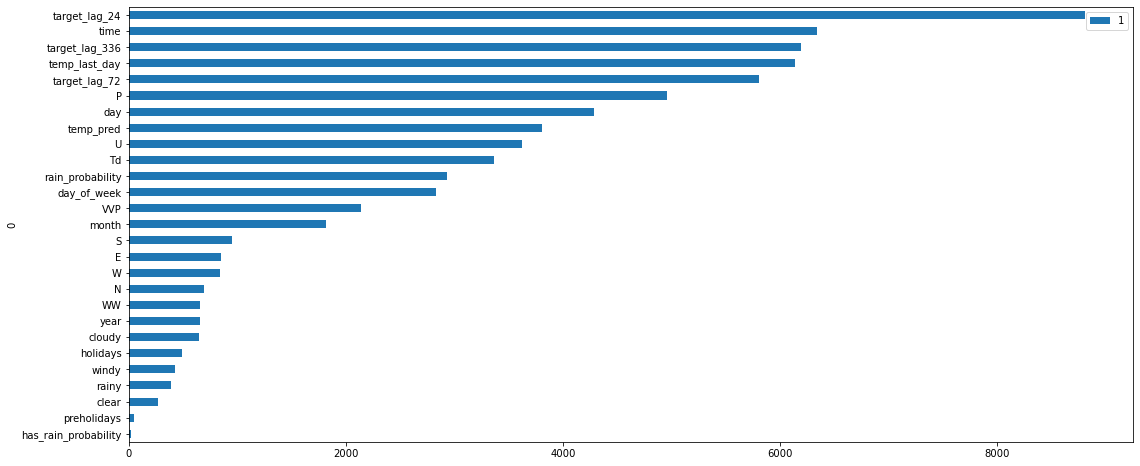

In [308]:
# График важности признаков

tmp_feature_cols = feature_cols.copy()
tmp_feature_cols.remove('date')
feature_importances = pd.DataFrame([tmp_feature_cols, lgbm_model.feature_importances_]).T.sort_values(by = 1)
feature_importances.plot(kind='barh', x=0, y=1, figsize=(18, 8))

In [309]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете

lgbm_model_all_train = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=NUM_ITERATIONS, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model_all_train.fit(features_all_train, target_all_train)

mae = mae_day(target_open_test, lgbm_model_all_train.predict(features_open_test))
print(f'mae_of_the_day - {mae}')

c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875
mae_of_the_day - 112.62385423745512


In [310]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете

lgbm_model_all_train = lgb.LGBMRegressor(num_leaves=15, learning_rate=0.02, num_iterations=NUM_ITERATIONS, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model_all_train.fit(features_all_train, target_all_train)

mae = mae_day(target_open_test, lgbm_model_all_train.predict(features_open_test))
print(f'mae_of_the_day - {mae}')

[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


mae_of_the_day - 108.5362345252902


In [311]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете

lgbm_model_all_train = lgb.LGBMRegressor(num_leaves=15, learning_rate=0.02, num_iterations=NUM_ITERATIONS, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model_all_train.fit(features_all_train, target_all_train)

mae_train, mape_train, r2_train = metrics_day(target_all_train, lgbm_model_all_train.predict(features_all_train))
mae_open_test, mape_open_test, r2_open_test = metrics_day(target_open_test, lgbm_model_all_train.predict(features_open_test))

print()
print(f'Train dataset MAE: {mae_train},    MAPE: {mape_train},    R2:{r2_train}')
print(f'Open test dataset MAE: {mae_open_test},    MAPE: {mape_open_test},    R2:{r2_open_test}')

[LightGBM] [Warning] feature_fraction is set=0.9875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Train dataset MAE: 74.91912353283898,    MAPE: 0.006779561629830199,    R2:0.9959383649611947
Open test dataset MAE: 108.5362345252902,    MAPE: 0.010746684469974977,    R2:0.9749940553928784


In [312]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете

lgbm_model_all_train = lgb.LGBMRegressor(num_leaves=15, learning_rate=0.02, num_iterations=NUM_ITERATIONS, 
                               random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model_all_train.fit(features_all_train, target_all_train)

mae_train, mape_train, r2_train = metrics_day(target_all_train, lgbm_model_all_train.predict(features_all_train))
mae_open_test, mape_open_test, r2_open_test = metrics_day(target_open_test, lgbm_model_all_train.predict(features_open_test))

print()
print(f'Train dataset MAE: {mae_train},    MAPE: {mape_train},    R2:{r2_train}')
print(f'Open test dataset MAE: {mae_open_test},    MAPE: {mape_open_test},    R2:{r2_open_test}')

c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Train dataset MAE: 74.91912353283898,    MAPE: 0.006779561629830199,    R2:0.9959383649611947
Open test dataset MAE: 108.5362345252902,    MAPE: 0.010746684469974977,    R2:0.9749940553928784


In [313]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете

lgbm_model_all_train = lgb.LGBMRegressor(num_leaves=15, learning_rate=0.05, num_iterations=NUM_ITERATIONS, 
                               random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model_all_train.fit(features_all_train, target_all_train)

mae_train, mape_train, r2_train = metrics_day(target_all_train, lgbm_model_all_train.predict(features_all_train))
mae_open_test, mape_open_test, r2_open_test = metrics_day(target_open_test, lgbm_model_all_train.predict(features_open_test))

print()
print(f'Train dataset MAE: {mae_train},    MAPE: {mape_train},    R2:{r2_train}')
print(f'Open test dataset MAE: {mae_open_test},    MAPE: {mape_open_test},    R2:{r2_open_test}')

c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Train dataset MAE: 55.197724140811324,    MAPE: 0.004989445765677688,    R2:0.9976118348849259
Open test dataset MAE: 108.86871067032088,    MAPE: 0.01074363932628511,    R2:0.9755334968382756


In [314]:
predict_open_test = lgbm_model_all_train.predict(features_open_test)

predict_result = pd.DataFrame( features.loc[features_open_test.index, 'date'] )
predict_result['predict'] = predict_open_test
predict_result = predict_result.groupby(by='date').sum().reset_index()
predict_result


,date,predict
0,2023-04-01,12221.702217
1,2023-04-02,11839.594779
2,2023-04-03,12495.606592
3,2023-04-04,12876.841909
4,2023-04-05,13084.867281
...,...,...
117,2023-07-27,9718.263977
118,2023-07-28,9735.738005
119,2023-07-29,9427.431495
120,2023-07-30,9261.650472
